## CycleGAN with Resnet Blocks

In this notebook, we try to implement CycleGAN with the resnet blocks as seen in the paper (https://arxiv.org/abs/1703.10593)



In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### Import Libraries

In [2]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
import PIL.Image as Image

import tensorflow as tf
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img

AUTOTUNE = tf.data.AUTOTUNE

Take a look at data

In [13]:
fifth = tf.keras.preprocessing.image_dataset_from_directory(
  "/content/drive/MyDrive/Small SG-VG",
  validation_split=0.8,
  subset="training",
  seed=420,
  image_size=(320,320),
  batch_size=1)

Found 262 files belonging to 2 classes.
Using 53 files for training.


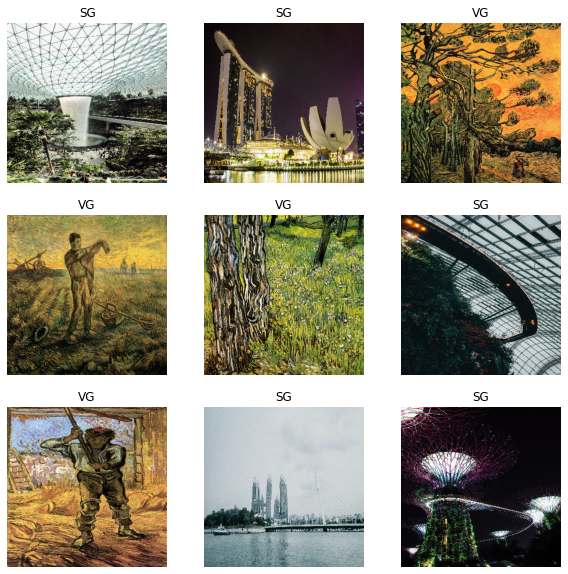

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for (i, (image, label)) in enumerate(fifth.take(9)):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image[0].numpy().astype("uint8"))
  plt.title(fifth.class_names[label[0]])
  plt.axis("off")

In [15]:
vg = fifth.filter(lambda x, y: tf.reduce_all(tf.not_equal(y, [0])))
sg = fifth.filter(lambda x, y: tf.reduce_all(tf.not_equal(y, [1])))

This is the Data Augmentation we plan on using for our model. It includes Random copping, Normalizing and Random Jitter.

Our Augmentation function is called on our original dataset every epoch so we have varied training images ever epoch

Our data loaded in (320, 320) and reshaped to (286x286) and cropped to (256, 256) and jittered

In [16]:
BUFFER_SIZE = 1000
BATCH_SIZE = 1
IMG_WIDTH = 256
IMG_HEIGHT = 256 

def random_crop(image):
    cropped_image = tf.image.random_crop(
      image, size=[IMG_HEIGHT, IMG_WIDTH, 3])
    return cropped_image

# normalizing the images to [-1, 1]
def normalize(image):
    image = tf.cast(image, tf.float32)
    image = (image / 127.5) - 1
    return image

def random_jitter(image):
    # resizing to 286 x 286 x 3
    image = tf.image.resize(image, [286, 286],
                            method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

    # randomly cropping to 256 x 256 x 3
    image = random_crop(image)
  
    # random mirroring
    image = tf.image.random_flip_left_right(image)
  
    return image  

def preprocess_image_train(image, label):
    image = image[0]
    image = random_jitter(image)
    image = normalize(image)
    # return (image, label)
    return image

This is the instance normalization layer from (https://github.com/xhujoy/CycleGAN-tensorflow)

In [17]:
class InstanceNormalization(tf.keras.layers.Layer):
  """Instance Normalization Layer (https://arxiv.org/abs/1607.08022)."""

  def __init__(self, epsilon=1e-5):
    super(InstanceNormalization, self).__init__()
    self.epsilon = epsilon

  def build(self, input_shape):
    self.scale = self.add_weight(
        name='scale',
        shape=input_shape[-1:],
        initializer=tf.random_normal_initializer(1., 0.02),
        trainable=True)

    self.offset = self.add_weight(
        name='offset',
        shape=input_shape[-1:],
        initializer='zeros',
        trainable=True)

  def call(self, x):
    mean, variance = tf.nn.moments(x, axes=[1, 2], keepdims=True)
    inv = tf.math.rsqrt(variance + self.epsilon)
    normalized = (x - mean) * inv
    return self.scale * normalized + self.offset

The resnet block that we will be using

In [18]:
def resnet_block(n_filters, input_layer):
	# weight initialization
	init = tf.random_normal_initializer(0., 0.02)
	# first layer convolutional layer
	g = tf.keras.layers.Conv2D(n_filters, (3,3), padding='same', kernel_initializer=init)(input_layer)
	g = InstanceNormalization()(g)
	g = tf.keras.layers.Activation('relu')(g)
	# second convolutional layer
	g = tf.keras.layers.Conv2D(n_filters, (3,3), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization()(g)
	# concatenate merge channel-wise with input layer
	g = tf.keras.layers.Concatenate()([g, input_layer])
	return g

Now, we can build the generator

In [20]:
def Generator():
  # weight initialization
  init = tf.random_normal_initializer(0., 0.02)
  # image input
  in_image = tf.keras.layers.Input(shape=[256,256,3])
  # c7s1-64
  g = tf.keras.layers.Conv2D(64, (7,7), padding='same', kernel_initializer=init)(in_image)
  g = InstanceNormalization()(g)
  g = tf.keras.layers.Activation('relu')(g)
	# d128
  g = tf.keras.layers.Conv2D(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
  g = InstanceNormalization()(g)
  g = tf.keras.layers.Activation('relu')(g)
  # d256
  g = tf.keras.layers.Conv2D(256, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
  g = InstanceNormalization()(g)
  g = tf.keras.layers.Activation('relu')(g)
	# R256
  for _ in range(9):
    g = resnet_block(256, g)
	# u128
  g = tf.keras.layers.Conv2DTranspose(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
  g = InstanceNormalization()(g)
  g = tf.keras.layers.Activation('relu')(g)
	# u64
  g = tf.keras.layers.Conv2DTranspose(64, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
  g = InstanceNormalization()(g)
  g = tf.keras.layers.Activation('relu')(g)
	# c7s1-3
  g = tf.keras.layers.Conv2D(3, (7,7), padding='same', kernel_initializer=init)(g)
  g = InstanceNormalization()(g)
  out_image = tf.keras.layers.Activation('tanh')(g)
	# define model
  model = tf.keras.Model(in_image, out_image)
  return model

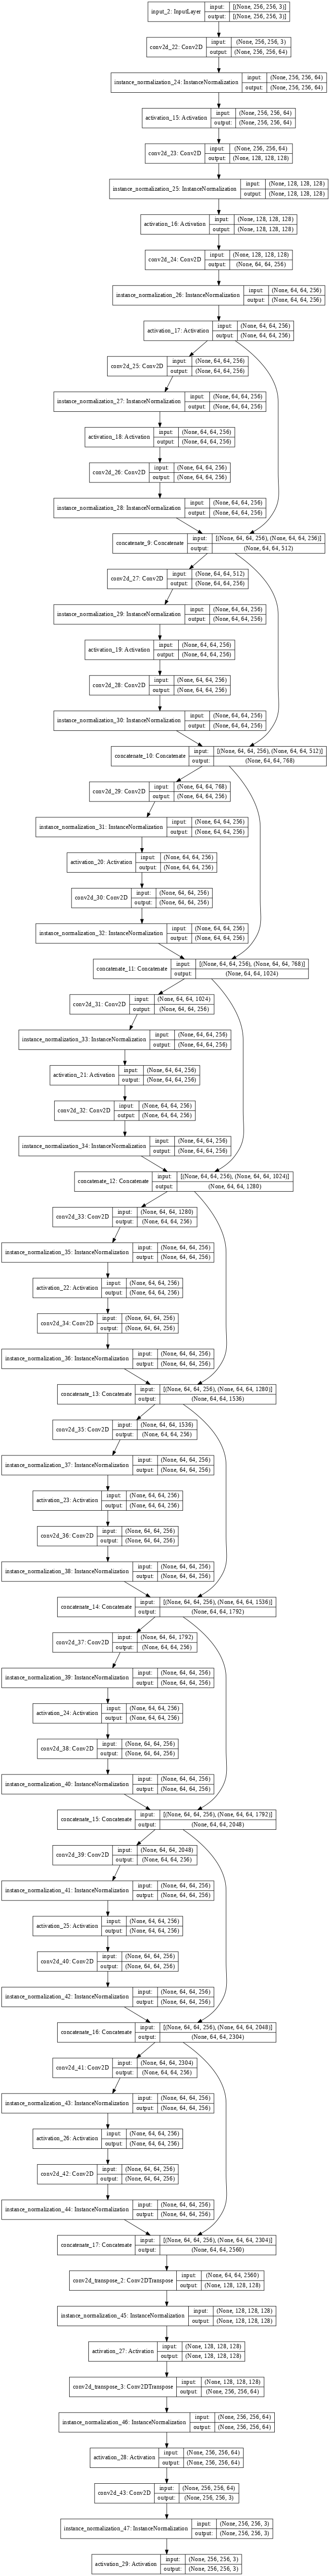

In [21]:
generator = Generator()
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

Looks Good! Now the Discriminator.

In [22]:
# define the discriminator model
def Discriminator():
	# weight initialization
  init = tf.random_normal_initializer(0., 0.02)
  # src imgs
  inp = tf.keras.layers.Input(shape=[256, 256, 3], name='input_image')
  tar = tf.keras.layers.Input(shape=[256, 256, 3], name='target_image')
  d = tf.keras.layers.concatenate([inp, tar]) # (bs, 256, 256, channels*2)
	# C64
  d = tf.keras.layers.Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(inp)
  d = tf.keras.layers.LeakyReLU(alpha=0.2)(d)
	# C128
  d = tf.keras.layers.Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
  d = InstanceNormalization()(d)
  d = tf.keras.layers.LeakyReLU(alpha=0.2)(d)
	# C256
  d = tf.keras.layers.Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
  d = InstanceNormalization()(d)
  d = tf.keras.layers.LeakyReLU(alpha=0.2)(d)
	# C512
  d = tf.keras.layers.Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
  d = InstanceNormalization()(d)
  d = tf.keras.layers.LeakyReLU(alpha=0.2)(d)
	# second last output layer
  d = tf.keras.layers.Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d)
  d = InstanceNormalization()(d)
  d = tf.keras.layers.LeakyReLU(alpha=0.2)(d)
	# patch output
  patch_out = tf.keras.layers.Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d)
	# define model
  # model = tf.keras.Model(inputs=[inp, tar], outputs=patch_out)
  model = tf.keras.Model(inputs=inp, outputs=patch_out)
  return model

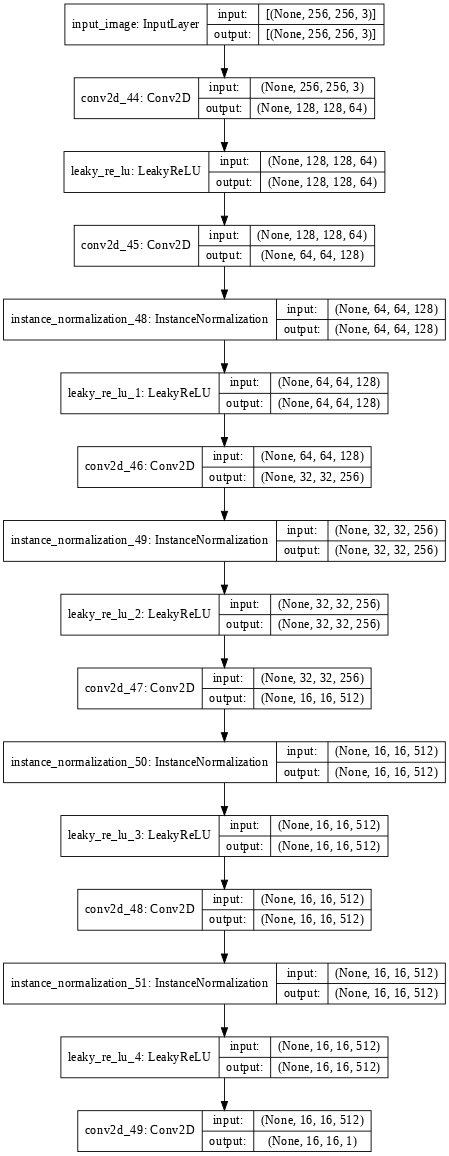

In [23]:
discriminator = Discriminator()
tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)

We also need the loss function. In this case, CycleGAN wants the image from one class of images to look like the other after cycling through both sets of GANs and judging how far the image looks from the original.

This is in essence our loss function, which we create here.

In [24]:
LAMBDA = 10
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [25]:
def discriminator_loss(real, generated):
  real_loss = loss_obj(tf.ones_like(real), real)

  generated_loss = loss_obj(tf.zeros_like(generated), generated)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss * 0.5

In [26]:
def generator_loss(generated):
  return loss_obj(tf.ones_like(generated), generated)

In [27]:
def calc_cycle_loss(real_image, cycled_image):
  loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

  return LAMBDA * loss1

In [28]:
def identity_loss(real_image, same_image):
  loss = tf.reduce_mean(tf.abs(real_image - same_image))
  return LAMBDA * 0.5 * loss

In [29]:
generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

CycleGAN contains 2 pairs of Generators and Discriminators, each pair of GAN learns convert and differentiate between 2 sets of images (in this case Singapore Pictures and Van Gogh Paintings).

Let's make the model

In [30]:
OUTPUT_CHANNELS = 3

generator_g = Generator()
generator_f = Generator()

discriminator_x = Discriminator()
discriminator_y = Discriminator()

In [31]:
checkpoint_path = "/content/drive/MyDrive/new test model"

ckpt = tf.train.Checkpoint(generator_g=generator_g,
                           generator_f=generator_f,
                           discriminator_x=discriminator_x,
                           discriminator_y=discriminator_y,
                           generator_g_optimizer=generator_g_optimizer,
                           generator_f_optimizer=generator_f_optimizer,
                           discriminator_x_optimizer=discriminator_x_optimizer,
                           discriminator_y_optimizer=discriminator_y_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=3)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print ('Latest checkpoint restored!!')

Latest checkpoint restored!!


Now that we have everything else, we need to create the train function where we try to minimise the loss function we defined earlier

In [34]:
@tf.function
def train_step(real_x, real_y):
  # persistent is set to True because the tape is used more than
  # once to calculate the gradients.
  with tf.GradientTape(persistent=True) as tape:
    # Generator G translates X -> Y
    # Generator F translates Y -> X.

    fake_y = generator_g(real_x, training=True)
    cycled_x = generator_f(fake_y, training=True)

    fake_x = generator_f(real_y, training=True)
    cycled_y = generator_g(fake_x, training=True)

    # same_x and same_y are used for identity loss.
    same_x = generator_f(real_x, training=True)
    same_y = generator_g(real_y, training=True)

    disc_real_x = discriminator_x(real_x, training=True)
    disc_real_y = discriminator_y(real_y, training=True)

    disc_fake_x = discriminator_x(fake_x, training=True)
    disc_fake_y = discriminator_y(fake_y, training=True)

    # calculate the loss
    gen_g_loss = generator_loss(disc_fake_y)
    gen_f_loss = generator_loss(disc_fake_x)

    total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)

    # Total generator loss = adversarial loss + cycle loss
    total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
    total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)

    disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
    disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)

  # Calculate the gradients for generator and discriminator
  generator_g_gradients = tape.gradient(total_gen_g_loss, 
                                        generator_g.trainable_variables)
  generator_f_gradients = tape.gradient(total_gen_f_loss, 
                                        generator_f.trainable_variables)

  discriminator_x_gradients = tape.gradient(disc_x_loss, 
                                            discriminator_x.trainable_variables)
  discriminator_y_gradients = tape.gradient(disc_y_loss, 
                                            discriminator_y.trainable_variables)

  # Apply the gradients to the optimizer
  generator_g_optimizer.apply_gradients(zip(generator_g_gradients, 
                                            generator_g.trainable_variables))

  generator_f_optimizer.apply_gradients(zip(generator_f_gradients, 
                                            generator_f.trainable_variables))

  discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients,
                                                discriminator_x.trainable_variables))

  discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients,
                                                discriminator_y.trainable_variables))

Finally, we can train our model! Let's define the number of epochs and make a function to generate images so we can watch the progress as we train our model.

In [35]:
EPOCHS = 450

In [33]:
def generate_images(model, test_input):
  prediction = model(test_input)

  plt.figure(figsize=(12, 12))

  display_list = [test_input[0], prediction[0]]
  title = ['Input Image', 'Predicted Image']

  for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

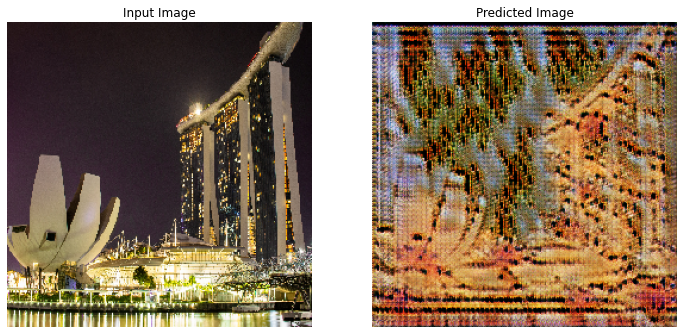

Saving checkpoint for epoch 450 at /content/drive/MyDrive/new test model/ckpt-5
Time taken for epoch 450 is 40.66448259353638 sec



In [38]:
for epoch in range(450):
  start = time.time()

  re_sg = sg.map(
    preprocess_image_train, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(1)

  re_vg = vg.map(
    preprocess_image_train, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(1)

  n = 0
  for image_x, image_y in tf.data.Dataset.zip((re_sg, re_vg)):
    train_step(image_x, image_y)
    if n % 5 == 0:
      print ('.', end='')
    n+=1

  clear_output(wait=True)
  generate_images(generator_g, next(iter(re_sg)))

  if (epoch + 1) % 150 == 0:
    ckpt_save_path = ckpt_manager.save()
    print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                         ckpt_save_path))

  print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                      time.time()-start))


Doesn't seem to be training that well....

Unfortunately, it takes a long time to train and we don't have time, so let's just take a look at the resutls

In [51]:
test = tf.keras.preprocessing.image_dataset_from_directory(
  "/content/drive/MyDrive/Small SG-VG",
  validation_split=0.8,
  subset="validation",
  seed=6969,
  batch_size=1)

Found 262 files belonging to 2 classes.
Using 209 files for validation.


In [52]:
sg_test = test.filter(lambda x, y: tf.reduce_all(tf.not_equal(y, [1])))

def preprocess_image_test(image, label):
  image = normalize(image)
  return image

sg_test = sg_test.map(
    preprocess_image_test, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

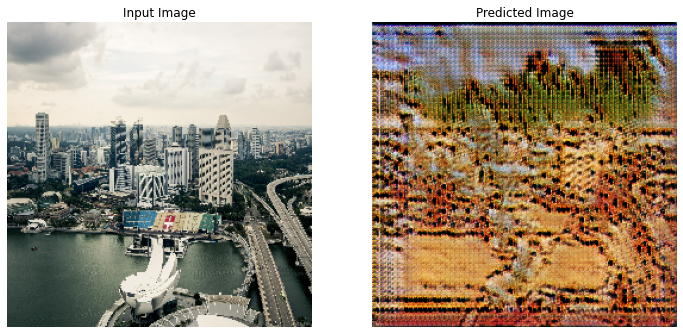

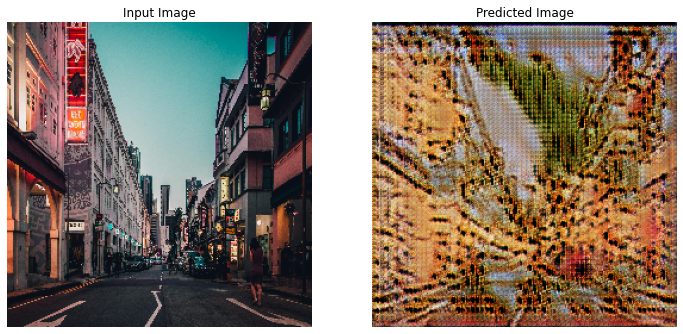

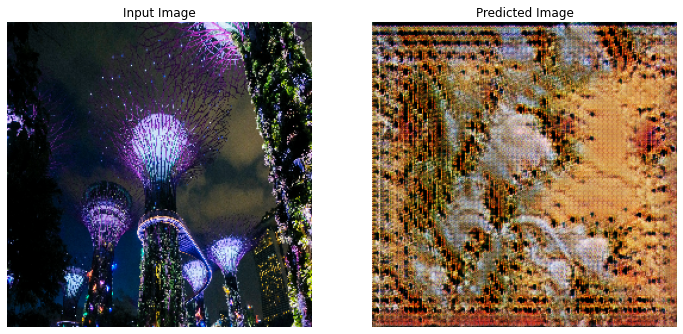

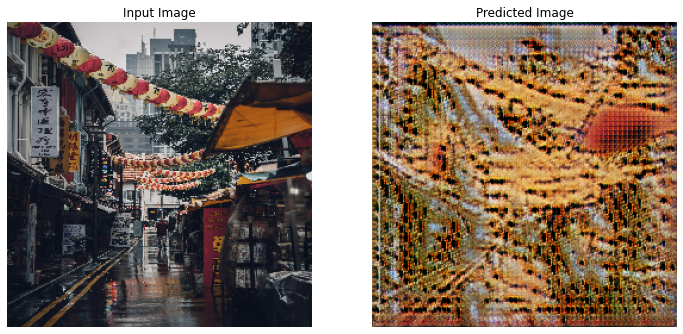

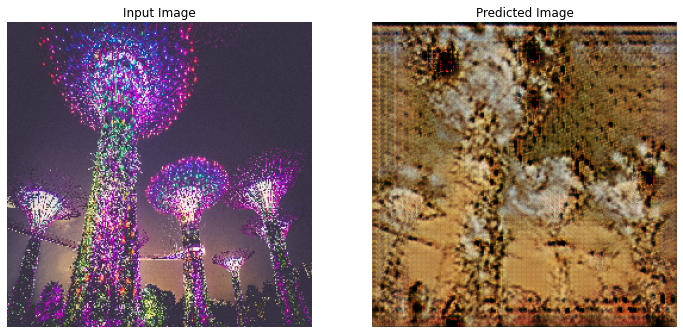

In [54]:
for inp in sg_test.take(5):
  generate_images(generator_g, inp[0]) 

Maybe much more training is needed or there is a minor flaw in the implementation. Our UNet CycleGAN is working much better, hence we should use that instead.

References:

https://www.tensorflow.org/tutorials/generative/pix2pix

https://github.com/tensorflow/examples/blob/master/tensorflow_examples/models/pix2pix/pix2pix.py

https://www.tensorflow.org/tutorials/generative/cyclegan#set_up_the_input_pipeline

https://machinelearningmastery.com/cyclegan-tutorial-with-keras/
